# Hero Lookup 

Experimenting with replacing hero id's with hero names, eda, visuals, etc. 

Motivation is figure out setup for trying bagofheroes/ hero2vec models 


In [46]:
import sys
sys.path.append('../')
import glob2 as glob

import copy
#import config
#import dota2api
import json
import requests
from pandas.io.json import json_normalize 


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
#import plotly.express as px

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200


import warnings; warnings.simplefilter('ignore')

In [2]:
import time
import datetime
import pytz

## Getting Hero Lookup 


https://medium.com/@waprin/python-and-dota2-analyzing-team-liquids-io-success-and-failure-7d44cc5979b2

This is the only method that I've gotten to consistently work. How is goes is: 
1. Pull the hero constants data from OpenDota api 
2. Create a hero dictionary from that json data pulled from OpenDota 

Get hero names and ids

In [3]:
!curl https://api.opendota.com/api/heroes > heroes.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20607    0 20607    0     0  50383      0 --:--:-- --:--:-- --:--:-- 50383


In [4]:
hero_dict = {}
with open('heroes.json') as f:
    data = json.load(f)
    for h in data:
        hero_dict[h['id']] = h['localized_name']
#print(hero_dict)

In [6]:
# # STEAM Client API Key to access the dota2 api
#API_KEY = config.(96E9FAA2D511E90BFE0F1CE229834E0C)
#api = dota2api.Initialise(API_KEY)

In [5]:
# Cleaner way to create columns for re-naming 

col2 = [f'{i}hero_id' for i in range(1, 23)]
print(col2)

['1hero_id', '2hero_id', '3hero_id', '4hero_id', '5hero_id', '6hero_id', '7hero_id', '8hero_id', '9hero_id', '10hero_id', '11hero_id', '12hero_id', '13hero_id', '14hero_id', '15hero_id', '16hero_id', '17hero_id', '18hero_id', '19hero_id', '20hero_id', '21hero_id', '22hero_id']


In [6]:
# Sklearn stuff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.model_selection import ShuffleSplit, KFold

SEED = 17

In [7]:
# Import Training and Test Data  
train_features = pd.read_csv('data2/dpc_train_features.csv', index_col='match_id')
train_targets = pd.read_csv('data2/dpc_train_target.csv', index_col='match_id')
test_features = pd.read_csv('data2/dpc_test_features.csv', index_col='match_id')
test_targets = pd.read_csv('data2/dpc_test_target.csv', index_col='match_id')

In [8]:
train_features.shape, train_targets.shape, test_features.shape, test_targets.shape

((1045, 66), (1045, 2), (117, 66), (117, 2))

In [9]:
all_features_df = pd.concat([train_features, test_features])

# Index to split the training and test data sets
idx_split = train_features.shape[0]

heroes_df = all_features_df[[f'{i}hero_id' for i in range(1, 23)]]

In [16]:
all_features_df1 = all_features_df.copy()
heroes_df1 = heroes_df.copy()

In [14]:
all_features_df1.shape, heroes_df1.shape

((1162, 66), (1162, 22))

In [33]:
# Combining all targets 
all_targets_df = pd.concat([train_targets, test_targets])
idx_split2 = train_targets.shape[0]

In [42]:
rwin_df = all_targets_df['radiant_win']
rwin_df.head()

match_id
5115031896    1
4865407245    0
4889341660    0
5050335216    1
4860032461    1
Name: radiant_win, dtype: int64

In [45]:
np.bincount(rwin_df)

array([596, 566])

Text(0.5, 1.0, 'Win Distribution')

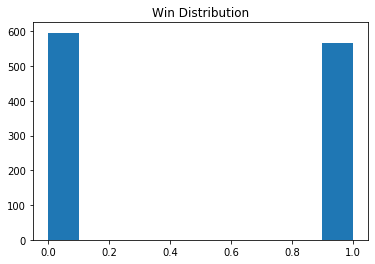

In [44]:
plt.hist(rwin_df)
plt.title('Win Distribution')

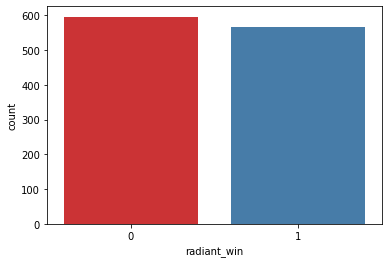

In [50]:
sns.countplot(x=rwin_df, palette="Set1");

Replacing Hero ID's with hero names 

In [17]:
# Run this once match data loaded in 

# https://github.com/codexponent/dota2-draft-analysis/blob/master/README.md

def change_hero_name(row):
    if row in hero_dict:
        return hero_dict[row]
    
columns = [
    '1hero_id',
    '2hero_id',
    '3hero_id',
    '4hero_id',
    '5hero_id',
    '6hero_id',
    '7hero_id',
    '8hero_id',
    '9hero_id',
    '10hero_id',
    '11hero_id',
    '12hero_id',
    '13hero_id',
    '14hero_id',
    '15hero_id',
    '16hero_id',
    '17hero_id',
    '18hero_id',
    '19hero_id',
    '20hero_id',
    '21hero_id',
    '22hero_id'
]
    
for i in range(len(columns)):
   all_features_df1[columns[i]] = all_features_df1[columns[i]].apply(change_hero_name)

In [18]:
all_features_df1.head()

,1is_pick,1team,1hero_id,2is_pick,2team,2hero_id,3is_pick,3team,3hero_id,4is_pick,4team,4hero_id,5is_pick,5team,5hero_id,6is_pick,6team,6hero_id,7is_pick,7team,7hero_id,8is_pick,8team,8hero_id,9is_pick,9team,9hero_id,10is_pick,10team,10hero_id,11is_pick,11team,11hero_id,12is_pick,12team,12hero_id,13is_pick,13team,13hero_id,14is_pick,14team,14hero_id,15is_pick,15team,15hero_id,16is_pick,16team,16hero_id,17is_pick,17team,17hero_id,18is_pick,18team,18hero_id,19is_pick,19team,19hero_id,20is_pick,20team,20hero_id,21is_pick,21team,21hero_id,22is_pick,22team,22hero_id
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5115031896,0,0,Lina,0,1,Chen,0,0,Night Stalker,0,1,Keeper of the Light,0,0,Earthshaker,0,1,Centaur Warrunner,1,0,Undying,1,1,Abaddon,1,1,Drow Ranger,1,0,Leshrac,0,0,Puck,0,1,Tiny,0,0,Templar Assassin,0,1,Timbersaw,1,1,Rubick,1,0,Vengeful Spirit,1,1,Gyrocopter,1,0,Lycan,0,1,Kunkka,0,0,Winter Wyvern,1,0,Mars,1,1,Axe
4865407245,0,1,Spirit Breaker,0,0,Sven,0,1,Dark Seer,0,0,Chen,0,1,Mars,0,0,Centaur Warrunner,1,1,Warlock,1,0,Grimstroke,1,0,Elder Titan,1,1,Tusk,0,1,Ember Spirit,0,0,Legion Commander,0,1,Sand King,0,0,Outworld Devourer,1,0,Batrider,1,1,Juggernaut,1,0,Templar Assassin,1,1,Omniknight,0,0,Monkey King,0,1,Morphling,1,1,Storm Spirit,1,0,Wraith King
4889341660,0,1,Techies,0,0,Earth Spirit,0,1,Grimstroke,0,0,Lone Druid,0,1,Rubick,0,0,Chen,1,1,Omniknight,1,0,Sven,1,0,Oracle,1,1,Troll Warlord,0,1,Centaur Warrunner,0,0,Shadow Fiend,0,1,Dark Seer,0,0,Leshrac,1,0,Shadow Demon,1,1,Shadow Shaman,1,0,Axe,1,1,Undying,0,0,Storm Spirit,0,1,Sniper,1,1,Outworld Devourer,1,0,Death Prophet
5050335216,0,0,Ogre Magi,0,1,Keeper of the Light,0,0,Tiny,0,1,Shadow Demon,0,0,Night Stalker,0,1,Kunkka,1,0,Elder Titan,1,1,Centaur Warrunner,1,1,Rubick,1,0,Ember Spirit,0,0,Broodmother,0,1,Morphling,0,0,Slark,0,1,Faceless Void,1,1,Warlock,1,0,Mirana,1,1,Gyrocopter,1,0,Outworld Devourer,0,1,Sand King,0,0,Queen of Pain,1,0,Underlord,1,1,Huskar
4860032461,0,1,Oracle,0,0,Sven,0,1,Doom,0,0,Dark Seer,0,1,Batrider,0,0,Juggernaut,1,1,Chen,1,0,Grimstroke,1,0,Sand King,1,1,Earth Spirit,0,1,Wraith King,0,0,Templar Assassin,0,1,Morphling,0,0,Lifestealer,1,0,Warlock,1,1,Centaur Warrunner,1,0,Ember Spirit,1,1,Outworld Devourer,0,0,Troll Warlord,0,1,Meepo,1,1,Anti-Mage,1,0,Alchemist


In [21]:
hero_picks_df = all_features_df1[[f'{i}hero_id' for i in range(1, 23)]]

In [22]:
hero_picks_df.head()

,1hero_id,2hero_id,3hero_id,4hero_id,5hero_id,6hero_id,7hero_id,8hero_id,9hero_id,10hero_id,11hero_id,12hero_id,13hero_id,14hero_id,15hero_id,16hero_id,17hero_id,18hero_id,19hero_id,20hero_id,21hero_id,22hero_id
match_id,,,,,,,,,,,,,,,,,,,,,,
5115031896,Lina,Chen,Night Stalker,Keeper of the Light,Earthshaker,Centaur Warrunner,Undying,Abaddon,Drow Ranger,Leshrac,Puck,Tiny,Templar Assassin,Timbersaw,Rubick,Vengeful Spirit,Gyrocopter,Lycan,Kunkka,Winter Wyvern,Mars,Axe
4865407245,Spirit Breaker,Sven,Dark Seer,Chen,Mars,Centaur Warrunner,Warlock,Grimstroke,Elder Titan,Tusk,Ember Spirit,Legion Commander,Sand King,Outworld Devourer,Batrider,Juggernaut,Templar Assassin,Omniknight,Monkey King,Morphling,Storm Spirit,Wraith King
4889341660,Techies,Earth Spirit,Grimstroke,Lone Druid,Rubick,Chen,Omniknight,Sven,Oracle,Troll Warlord,Centaur Warrunner,Shadow Fiend,Dark Seer,Leshrac,Shadow Demon,Shadow Shaman,Axe,Undying,Storm Spirit,Sniper,Outworld Devourer,Death Prophet
5050335216,Ogre Magi,Keeper of the Light,Tiny,Shadow Demon,Night Stalker,Kunkka,Elder Titan,Centaur Warrunner,Rubick,Ember Spirit,Broodmother,Morphling,Slark,Faceless Void,Warlock,Mirana,Gyrocopter,Outworld Devourer,Sand King,Queen of Pain,Underlord,Huskar
4860032461,Oracle,Sven,Doom,Dark Seer,Batrider,Juggernaut,Chen,Grimstroke,Sand King,Earth Spirit,Wraith King,Templar Assassin,Morphling,Lifestealer,Warlock,Centaur Warrunner,Ember Spirit,Outworld Devourer,Troll Warlord,Meepo,Anti-Mage,Alchemist


In [23]:
# Quick check that hero ids are unique (i.e., no double picking)
# https://www.kaggle.com/kuzand/dota-2-winner-prediction-multilayer-nn-pytorch

np.all(all_features_df1[[f'{i}hero_id' for i in range(1, 23)]].nunique(axis=1) == 22)

True

In [25]:
np.sort(np.unique(hero_picks_df[[f'{i}hero_id' for i in range(1, 23)]].values.flatten()))

array(['Abaddon', 'Alchemist', 'Ancient Apparition', 'Anti-Mage',
       'Arc Warden', 'Axe', 'Bane', 'Batrider', 'Beastmaster',
       'Bloodseeker', 'Bounty Hunter', 'Brewmaster', 'Bristleback',
       'Broodmother', 'Centaur Warrunner', 'Chaos Knight', 'Chen',
       'Clinkz', 'Clockwerk', 'Crystal Maiden', 'Dark Seer',
       'Dark Willow', 'Dazzle', 'Death Prophet', 'Disruptor', 'Doom',
       'Dragon Knight', 'Drow Ranger', 'Earth Spirit', 'Earthshaker',
       'Elder Titan', 'Ember Spirit', 'Enchantress', 'Enigma',
       'Faceless Void', 'Grimstroke', 'Gyrocopter', 'Huskar', 'Invoker',
       'Io', 'Jakiro', 'Juggernaut', 'Keeper of the Light', 'Kunkka',
       'Legion Commander', 'Leshrac', 'Lich', 'Lifestealer', 'Lina',
       'Lion', 'Lone Druid', 'Luna', 'Lycan', 'Magnus', 'Mars', 'Medusa',
       'Meepo', 'Mirana', 'Monkey King', 'Morphling', 'Naga Siren',
       "Nature's Prophet", 'Necrophos', 'Night Stalker', 'Nyx Assassin',
       'Ogre Magi', 'Omniknight', 'Oracle', '

In [26]:
(unique, counts) = np.unique(hero_picks_df[[f'{i}hero_id' for i in range(1, 23)]],return_counts=True) 
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[['Abaddon' 383]
 ['Alchemist' 362]
 ['Ancient Apparition' 358]
 ['Anti-Mage' 116]
 ['Arc Warden' 69]
 ['Axe' 239]
 ['Bane' 128]
 ['Batrider' 341]
 ['Beastmaster' 266]
 ['Bloodseeker' 156]
 ['Bounty Hunter' 36]
 ['Brewmaster' 41]
 ['Bristleback' 176]
 ['Broodmother' 196]
 ['Centaur Warrunner' 484]
 ['Chaos Knight' 128]
 ['Chen' 637]
 ['Clinkz' 12]
 ['Clockwerk' 56]
 ['Crystal Maiden' 221]
 ['Dark Seer' 228]
 ['Dark Willow' 123]
 ['Dazzle' 85]
 ['Death Prophet' 260]
 ['Disruptor' 76]
 ['Doom' 81]
 ['Dragon Knight' 68]
 ['Drow Ranger' 63]
 ['Earth Spirit' 124]
 ['Earthshaker' 302]
 ['Elder Titan' 197]
 ['Ember Spirit' 746]
 ['Enchantress' 277]
 ['Enigma' 304]
 ['Faceless Void' 554]
 ['Grimstroke' 402]
 ['Gyrocopter' 574]
 ['Huskar' 70]
 ['Invoker' 217]
 ['Io' 276]
 ['Jakiro' 118]
 ['Juggernaut' 336]
 ['Keeper of the Light' 369]
 ['Kunkka' 715]
 ['Legion Commander' 235]
 ['Leshrac' 613]
 ['Lich' 119]
 ['Lifestealer' 460]
 ['Lina' 507]
 ['Lion' 58]
 ['Lone Druid' 88]
 ['Luna' 12]
 ['Lycan'

In [27]:
# Re-label the re-labeled dataframes to make my life easier 

df = all_features_df1
picks_df = hero_picks_df

In [75]:
# First ban heroes 

ban1 = df['1hero_id']
ban1_count = df.groupby(ban1).size()
#ban1_count

In [76]:
# get top x value counts
ban1.value_counts().nlargest(5)

Chen            106
Magnus           65
Leshrac          57
Shadow Demon     57
Mirana           52
Name: 1hero_id, dtype: int64

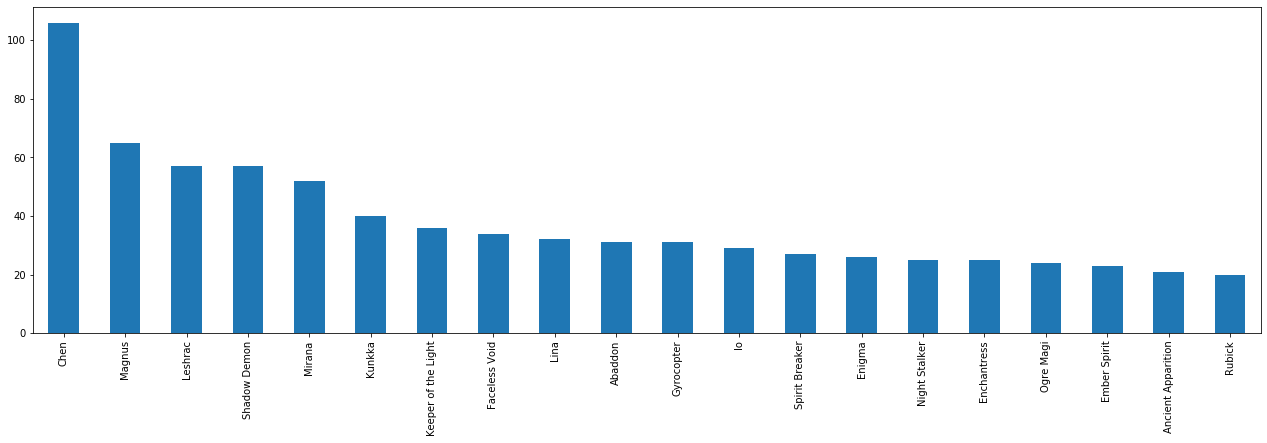

In [79]:
ban1.value_counts().nlargest(20).plot(kind='bar');

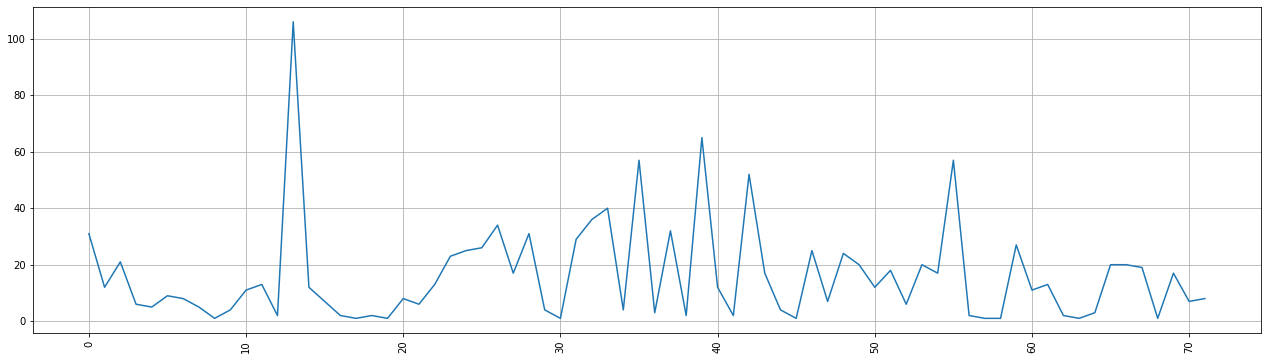

In [57]:
plt.rcParams['figure.figsize'] = 22, 6
plt.xticks(rotation='vertical')
plt.grid()
plt.plot(ban1_count.values) #.index, ban1_count.values)

Make pick/ban variables for each of the picks/bans.

- 1-6 = first phase bans
- 7-10 = first phase picks 
- 11-14 = second phase bans 
- 15-18 = second phase picks 
- 19-20 = thirst phase bans
- 21-22 = third phase picks 

For either team, pick and ban order goes: 3 bans, 2 picks, 2 bans, 2picks, 1 ban, 1 pick. Let's standardize our lingo here, hero 'selection' refers to a team choosing a hero to be picked and/or banned.


SPS team 1 picks first, then 

Team 1's picks/bans out of the 22 order, would be 
- SELECTIONS: 1, 3, 5, 7, 10, 11, 13, 16, 18, 20, 21 
- BANS: 1, 3, 5, 11, 13, 20 
- PICKS: 7, 10, 16, 18, 21 PICKS

Team 2's would then be: 
- SELECTIONS: 2, 4, 6, 8, 9, 12, 14, 15, 17, 19 , 22 
- BANS: 2, 4, 6, 12, 14, 19
- PICKS: 8, 9, 15, 17, 22

In [83]:
bans = [f'ban{i}' for i in range(1, 13)]
print(bans)

['ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'ban6', 'ban7', 'ban8', 'ban9', 'ban10', 'ban11', 'ban12']


In [85]:
# get list without quotations 
print (*bans, sep =', ') 

ban1, ban2, ban3, ban4, ban5, ban6, ban7, ban8, ban9, ban10, ban11, ban12


In [63]:
# First Phase Bans 
ban1 = df['1hero_id']
ban2 = df['2hero_id']
ban3 = df['3hero_id']
ban4 = df['4hero_id']
ban5 = df['5hero_id']
ban6 = df['6hero_id']

# First Phase Picks 
pick1 = df['7hero_id']
pick2 = df['8hero_id']
pick3 = df['9hero_id']
pick4 = df['10hero_id']

# Second phase bans 
ban7 = df['11hero_id']
ban8 = df['12hero_id']
ban9 = df['13hero_id']
ban10 = df['14hero_id']

# Second phase picks 
pick5 = df['15hero_id']
pick6 = df['16hero_id']
pick7 = df['17hero_id']
pick8 = df['18hero_id']

# Third phase bans
ban11 = df['19hero_id']
ban12 = df['20hero_id']

# Third phase picks 
pick9 = df['21hero_id']
pick10 = df['22hero_id']

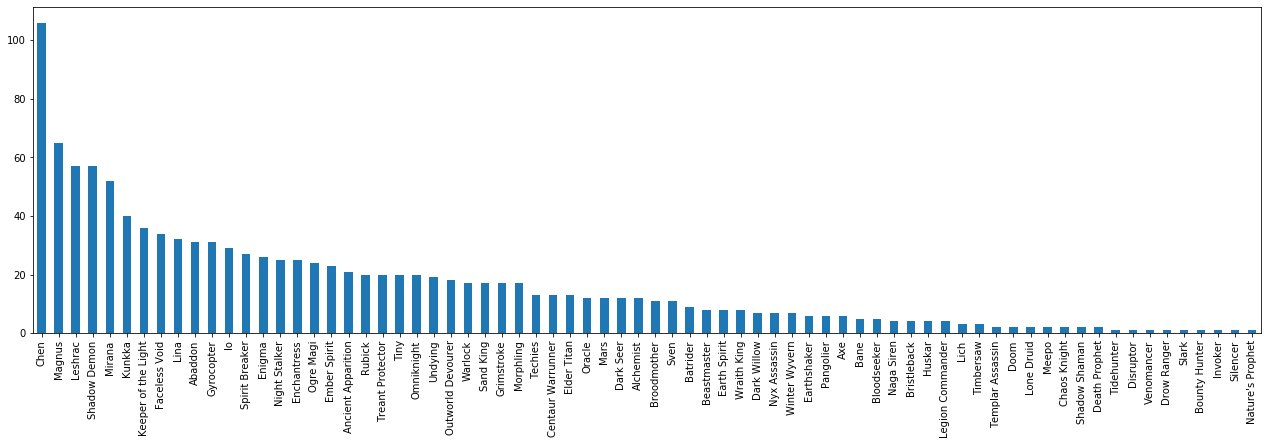

In [69]:
ban1.value_counts().plot(kind='bar');

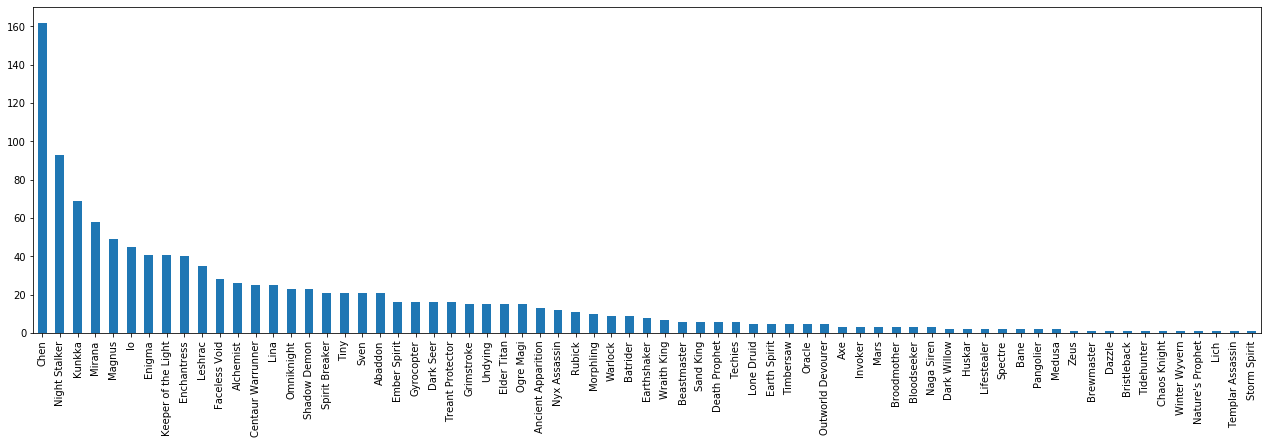

In [70]:
ban2.value_counts().plot(kind='bar');

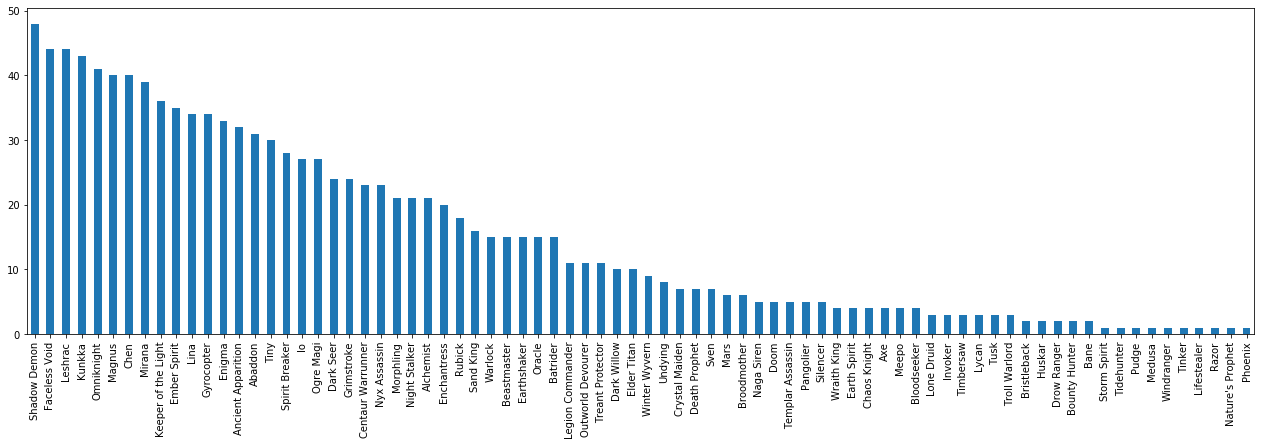

In [71]:
ban3.value_counts().plot(kind='bar');

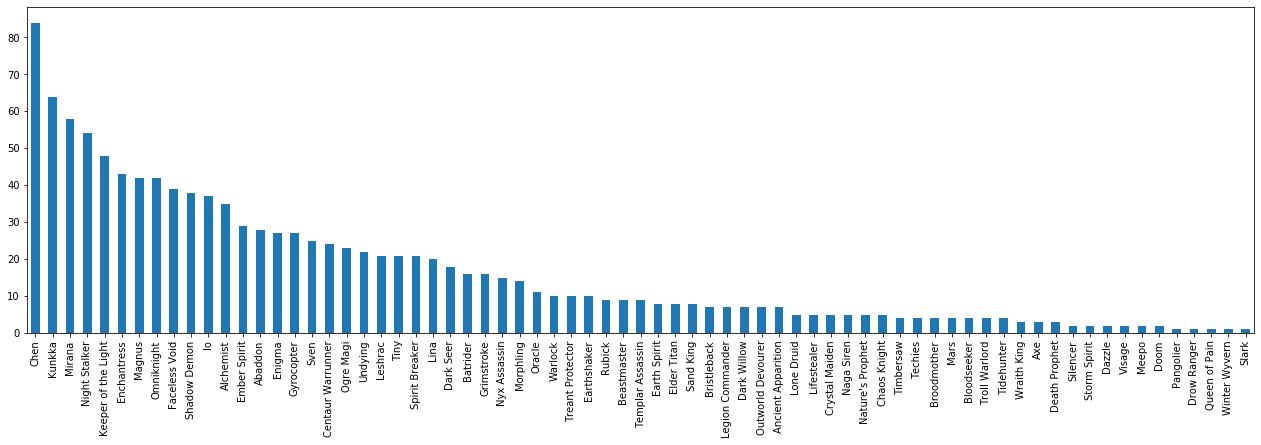

In [72]:
ban4.value_counts().plot(kind='bar');

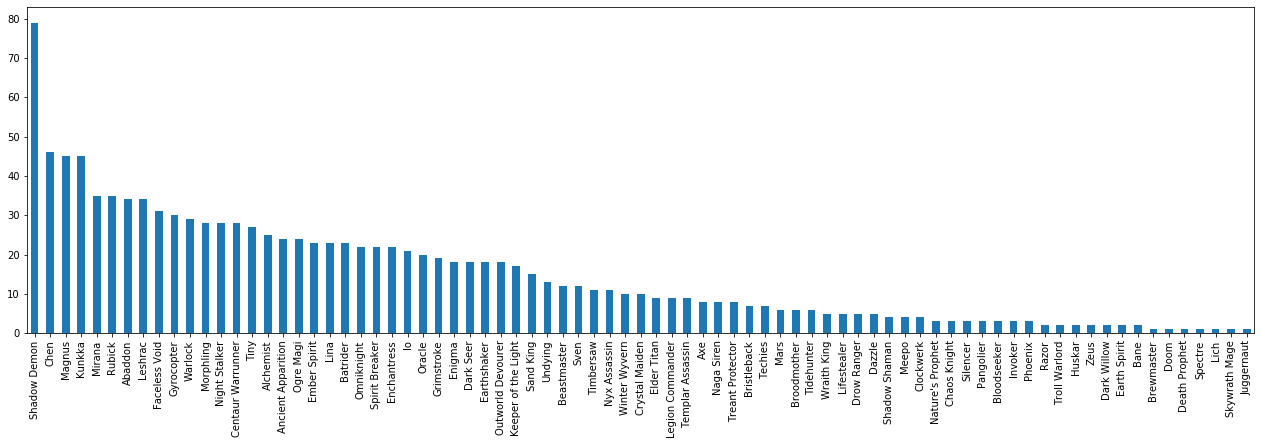

In [73]:
ban5.value_counts().plot(kind='bar');

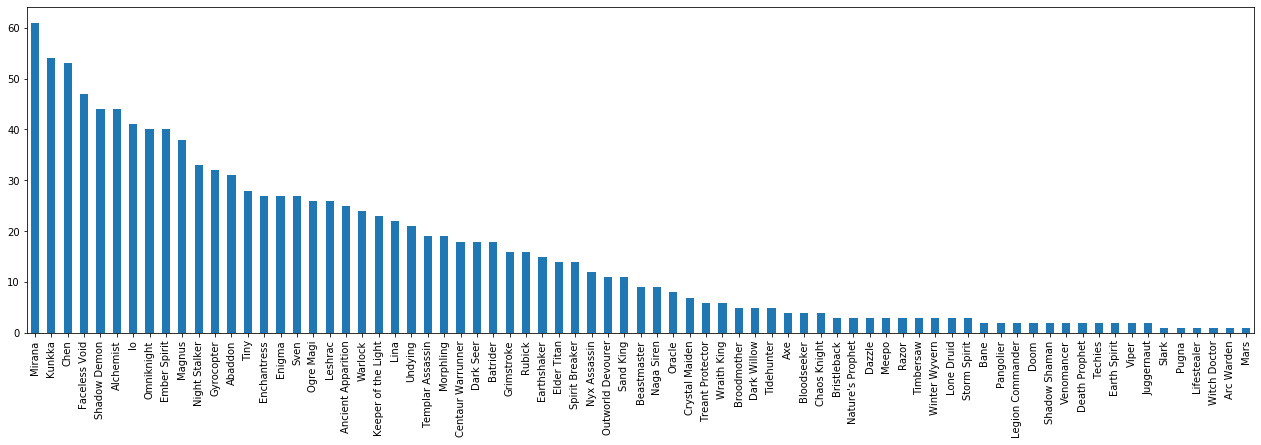

In [74]:
ban6.value_counts().plot(kind='bar');

In [86]:
import shap

ModuleNotFoundError: No module named 'shap'

## Hot Encoding Procedure

In [17]:
heroes_df_ohe = heroes_df.copy()
for i in range(1, 23):
    heroes_df_ohe = pd.get_dummies(heroes_df_ohe, columns = [f'{i}hero_id'])
        
heroes_df_ohe.head()

X_heroes_train = heroes_df_ohe[:idx_split] # features set is only picks + dummies
X_heroes_test  = heroes_df_ohe[idx_split:]

In [18]:
print(f'Number of features: {heroes_df_ohe.shape[1]}')

Number of features: 2044


In [19]:
X_heroes_train.shape, X_heroes_test.shape

((1045, 2044), (117, 2044))

In [20]:
X_heroes_train.head()

,1hero_id_2,1hero_id_3,1hero_id_4,1hero_id_6,1hero_id_7,1hero_id_9,1hero_id_10,1hero_id_16,1hero_id_18,1hero_id_19,1hero_id_23,1hero_id_25,1hero_id_27,1hero_id_29,1hero_id_31,1hero_id_33,1hero_id_37,1hero_id_38,1hero_id_40,1hero_id_41,1hero_id_42,1hero_id_43,1hero_id_46,1hero_id_52,1hero_id_53,1hero_id_55,1hero_id_57,1hero_id_58,1hero_id_59,1hero_id_60,1hero_id_61,1hero_id_62,1hero_id_65,1hero_id_66,1hero_id_68,1hero_id_69,1hero_id_71,1hero_id_72,1hero_id_73,1hero_id_74,1hero_id_75,1hero_id_76,1hero_id_79,1hero_id_80,1hero_id_81,1hero_id_82,1hero_id_83,1hero_id_84,1hero_id_85,1hero_id_86,1hero_id_87,1hero_id_88,1hero_id_89,1hero_id_90,1hero_id_91,1hero_id_93,1hero_id_96,1hero_id_97,1hero_id_98,1hero_id_99,1hero_id_102,1hero_id_103,1hero_id_104,1hero_id_105,1hero_id_106,1hero_id_107,1hero_id_111,1hero_id_112,1hero_id_119,1hero_id_120,1hero_id_121,1hero_id_129,2hero_id_2,2hero_id_3,2hero_id_4,2hero_id_7,2hero_id_9,2hero_id_10,2hero_id_16,2hero_id_17,2hero_id_18,2hero_id_19,2hero_id_22,2hero_id_23,2hero_id_25,2hero_id_29,2hero_id_31,2hero_id_33,2hero_id_37,2hero_id_38,2hero_id_41,2hero_id_42,2hero_id_43,2hero_id_46,2hero_id_50,2hero_id_52,2hero_id_53,2hero_id_54,2hero_id_55,2hero_id_57,...,22hero_id_1,22hero_id_2,22hero_id_4,22hero_id_5,22hero_id_6,22hero_id_7,22hero_id_8,22hero_id_10,22hero_id_11,22hero_id_12,22hero_id_13,22hero_id_14,22hero_id_15,22hero_id_16,22hero_id_17,22hero_id_18,22hero_id_19,22hero_id_21,22hero_id_22,22hero_id_23,22hero_id_25,22hero_id_26,22hero_id_27,22hero_id_28,22hero_id_29,22hero_id_32,22hero_id_33,22hero_id_34,22hero_id_35,22hero_id_36,22hero_id_37,22hero_id_38,22hero_id_39,22hero_id_40,22hero_id_41,22hero_id_42,22hero_id_43,22hero_id_44,22hero_id_45,22hero_id_46,22hero_id_47,22hero_id_48,22hero_id_49,22hero_id_50,22hero_id_51,22hero_id_52,22hero_id_53,22hero_id_54,22hero_id_55,22hero_id_56,22hero_id_57,22hero_id_58,22hero_id_59,22hero_id_60,22hero_id_61,22hero_id_62,22hero_id_63,22hero_id_65,22hero_id_67,22hero_id_68,22hero_id_70,22hero_id_71,22hero_id_72,22hero_id_73,22hero_id_74,22hero_id_75,22hero_id_76,22hero_id_77,22hero_id_78,22hero_id_79,22hero_id_80,22hero_id_81,22hero_id_82,22hero_id_84,22hero_id_85,22hero_id_86,22hero_id_88,22hero_id_89,22hero_id_92,22hero_id_93,22hero_id_94,22hero_id_95,22hero_id_96,22hero_id_97,22hero_id_98,22hero_id_99,22hero_id_101,22hero_id_102,22hero_id_104,22hero_id_106,22hero_id_107,22hero_id_108,22hero_id_109,22hero_id_110,22hero_id_112,22hero_id_113,22hero_id_114,22hero_id_120,22hero_id_121,22hero_id_129
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5115031896,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4865407245,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4889341660,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5050335216,0,0,0,0,0,0,0,0,0,0,0

Hot encoding by getting dummies for each hero_id feature.

*Note: Not every 117 heroes were chosen for each pick (1-22). Therefore, columns will be less than 22 x 117

In [27]:
all_features = pd.concat([train_features, test_features])

# Index to split the training and test data sets
idx_split = train_features.shape[0]

In [28]:
for i in range(1,23):
        all_features = pd.get_dummies(all_features, columns = [f'{i}hero_id'])

print(all_features.shape)

(1162, 2088)


In [ ]:
#for i in range(1,23):
#        df_full_features = pd.get_dummies(df_full_features, columns = [f'{i}hero_id'])

In [ ]:
#df_full_features.shape # this should be same size as entire dataset